In [411]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
import time
import random
from albumentations import RandomCrop, HorizontalFlip, CenterCrop, Compose, Normalize
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.metrics import accuracy_score
import torchvision.models as models
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader  
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#print(os.listdir('../input/stanford-dogs-dataset'))

# Preprocessing
all code in this section adapted from https://www.kaggle.com/virajbagal/stanford-dogs-alexnet-paper-implementation-pytorch

## Load stanford dogs dataset

In [412]:
# kaggle paths
#annot_path = '../input/stanford-dogs-dataset/annotations/Annotation'
#image_path = '../input/stanford-dogs-dataset/images/Images'

# local paths
image_path = 'stanford-dogs-dataset/images/Images'
annot_path = 'stanford-dogs-dataset/annotations/Annotation'

In [136]:
print('Length of annotations :', len(os.listdir(annot_path)))
print('Length of image classes :', len(os.listdir(image_path)))
if len(os.listdir(annot_path)) == len(os.listdir(image_path)):
    print('Number of unique annotations matches the number of classes')
else:
    print("Number of unique annotations doesn't match the number of classes")

Length of annotations : 120
Length of image classes : 120
Number of unique annotations matches the number of classes


## Basic EDA

In [137]:
valid = []

for element in os.listdir(image_path):
    breed = element.split('-')[1]
    images = len(os.listdir(os.path.join(image_path,element)))
    valid.append((breed, images))

In [138]:
df = pd.DataFrame(valid, columns = ['Breeds', 'Number of images'])
print('Total number of images :', df['Number of images'].sum())

Total number of images : 20580


In [139]:
df.head()

,Breeds,Number of images
0,silky_terrier,183
1,Scottish_deerhound,232
2,Chesapeake_Bay_retriever,167
3,Ibizan_hound,188
4,wire,157


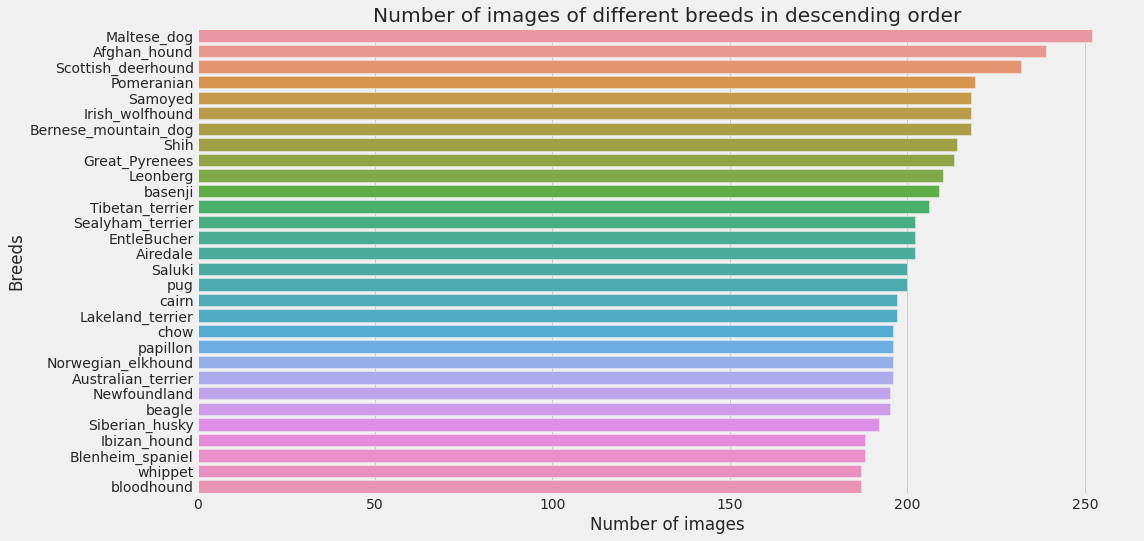

In [8]:
plt.figure(figsize=(15,8))
plt.title('Number of images of different breeds in descending order')
sns.barplot(x = 'Number of images', y = 'Breeds', data = df.sort_values('Number of images', ascending = False).head(30))
plt.show()

In [9]:
# temporary- only use 5 pure breeds and 5 mixed breeds
subset = df.sort_values('Number of images', ascending = False)['Breeds'][:5].values.tolist()
subset2 = df.sort_values('Number of images', ascending = True)['Breeds'][:5].values.tolist()

In [10]:
subset

['Maltese_dog', 'Afghan_hound', 'Scottish_deerhound', 'Pomeranian', 'Samoyed']

In [11]:
subset2

['redbone', 'Pekinese', 'Irish_water_spaniel', 'kuvasz', 'Eskimo_dog']

## Data Augmentations

In [140]:
valid = []

for element in os.listdir(image_path):
    #if element.split('-')[1] in subset or element.split('-')[1] in subset2:
        for img_id in os.listdir(os.path.join(image_path, element)):
            path = os.path.join(element, img_id)
            label = element.split('-')[1]
            valid.append((path, label))          
        
df = pd.DataFrame(valid, columns = ['Path', 'Label'])
print('Shape of dataframe :', df.shape)

Shape of dataframe : (20580, 2)


In [141]:
# Dataset with the suffix path and label

df.head()

,Path,Label
0,n02097658-silky_terrier/n02097658_26.jpg,silky_terrier
1,n02097658-silky_terrier/n02097658_4869.jpg,silky_terrier
2,n02097658-silky_terrier/n02097658_595.jpg,silky_terrier
3,n02097658-silky_terrier/n02097658_9222.jpg,silky_terrier
4,n02097658-silky_terrier/n02097658_422.jpg,silky_terrier


In [14]:
def aug1():
        return Compose([RandomCrop(height = 299, width = 299, p = 1.0), 
                        HorizontalFlip(p = 0.5),  
                        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ToTensorV2()], p = 1)

In [15]:
def aug2():
    return Compose([Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                    ToTensorV2()], p = 1)

In [16]:
train_aug = aug1()
valid_aug = aug2()

### PCA Color Augmentation

This augmentation was used in the AlexNet paper. Following is the excerpt from AlexNet paper. 
For more information refer to Alexnet Paper : https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

To each RGB image pixel I xy =
R
G
B T
[I xy
, I xy
, I xy
] we add the following quantity:
[p 1 , p 2 , p 3 ][α 1 λ 1 , α 2 λ 2 , α 3 λ 3 ] T
where p i and λ i are ith eigenvector and eigenvalue of the 3 × 3 covariance matrix of RGB pixel
values, respectively, and α i is the aforementioned random variable

In [17]:
def PCAColorAug(image, category = 'Tensor'):
    if type(image) == torch.Tensor:
        image = image.numpy()
        image = np.moveaxis(image, 0, 2)
    
    
    img_reshaped = image.reshape(-1, 3).astype('float32')
    mean, std = np.mean(img_reshaped, 0), np.std(img_reshaped, 0)
    img_rescaled = (img_reshaped - mean)/std
    cov_matrix = np.cov(img_rescaled, rowvar = False) # Covariant matrix of reshaped image.  Output is 3*3 matrix
    eigen_val, eigen_vec = np.linalg.eig(cov_matrix) # Compute Eigen Values and Eigen Vectors of the covariant matrix. eigen_vec is 3*3 matrix with eigen vectors as column. 
    alphas = np.random.normal(loc = 0, scale = 0.1, size = 3)
    vec1 = alphas*eigen_val
    valid = np.dot(eigen_vec, vec1) # Matrix multiplication
    pca_aug_norm_image = img_rescaled + valid
    pca_aug_image = pca_aug_norm_image*std + mean
    aug_image = np.maximum(np.minimum(pca_aug_image, 255), 0).astype('uint8')
    if category == 'Tensor':
        return torch.from_numpy(aug_image.reshape(3,299,299))
    else:
        return aug_image.reshape(299,299,3)
    

In [142]:
labels = pd.get_dummies(df['Label'])

## Dataset

In [40]:
import torchvision.transforms as transforms

class StanfordDogs(Dataset):
    def __init__(self, transform1, transform2, X, Y, objective = 'train'):
        self.X = X
        self.Y = Y
        self.train_transform = transform1
        self.valid_transform = transform2
        self.objective = objective
        
    def __getitem__(self, idx):
        path = self.X['Path'][idx]
        label = self.Y.iloc[idx, :].values
        img = cv2.imread(os.path.join(image_path, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Shortest side of image is scaled to 299 pixels and the other side is scaled so as to maintain aspect ratio
        
        h, w, _ = img.shape
        
        if h <= w:
            aspect_ratio = w/h
            dim = (299, int(299*aspect_ratio))
            img = cv2.resize(img, dim)
        else:
            aspect_ratio = h/w
            dim = (int(299*aspect_ratio), 299)
            img = cv2.resize(img, dim)

           
        img = CenterCrop(height = 299, width = 299, p = 1)(image = img)['image']
        
        if self.objective == 'train':
            random = np.random.uniform(size = 1)
            if random < 0.5:                            # PCA Augmentation carried out only 50 percent of time
                img = PCAColorAug(img, category = 'numpy')
                
            augmented = self.train_transform(image = img)
            img = augmented['image']
            
            return img, label
        
        elif ((self.objective == 'validation') |  (self.objective == 'test')):
            img = cv2.resize(img, (299, 299))
            augmented = self.valid_transform(image = img)
            img = augmented['image']  
            
            return img, label
        
    
    def __len__(self):
        return len(self.X)

In [20]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df, labels, test_size = 0.25, random_state = 5, stratify = df['Label'])
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size = 0.25, random_state = 5, stratify = train_X['Label'])

In [21]:
train_X.reset_index(drop = True, inplace = True)
val_X.reset_index(drop = True, inplace = True)
test_X.reset_index(drop = True, inplace = True)

train_y.reset_index(drop = True, inplace = True)
val_y.reset_index(drop = True, inplace = True)
test_y.reset_index(drop = True, inplace = True)

## Visualize Augmentations

(-0.5, 298.5, 298.5, -0.5)

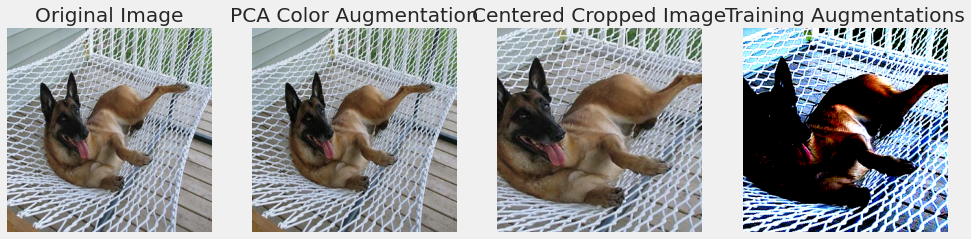

In [22]:
image = cv2.imread(image_path + '/n02105162-malinois/n02105162_6625.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image1 = cv2.resize(image, (299,299))
aug_image = PCAColorAug(image1, category = 'numpy')
cropped_img = CenterCrop(height = 299, width = 299, p = 1)(image = image)['image']
image2 = cv2.resize(cropped_img, (224,224))
image3 = train_aug(image = cropped_img)['image']
image3 = image3.numpy()
image3 = np.moveaxis(image3, 0, 2)
image3 = cv2.resize(image3, (299,299))

plt.figure(figsize = (15, 10))
plt.subplot(1,4,1)
plt.imshow(image1)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(aug_image)
plt.title('PCA Color Augmentation')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(image2)
plt.title('Centered Cropped Image')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(image3)
plt.title('Training Augmentations')
plt.axis('off')

In [36]:
BATCH_SIZE = 128

def loader(data_X, data_Y, batch_size = BATCH_SIZE, obj = 'train'):
    data = StanfordDogs(train_aug, valid_aug, X = data_X, Y = data_Y, objective = obj)
    loader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = True)
    
    return loader

In [24]:
train_loader = loader(train_X, train_y, batch_size = BATCH_SIZE)
val_loader = loader(val_X, val_y, batch_size = BATCH_SIZE, obj = 'validation')

# Train model on GPU

In [ ]:
# is a GPU available?
torch.cuda.is_available()

In [ ]:
# check who is using what
!nvidia-smi

In [ ]:
# how many devices are there?
torch.cuda.device_count()

In [ ]:
device_no = 0
if torch.cuda.is_available() == True:
    device = torch.device(device_no)
else:
    device = torch.device('cpu')
device

In [56]:
inception = models.inception_v3(pretrained = True, aux_logits=False)

In [57]:
# Freeze model parameters
for param in inception.parameters():
    param.requires_grad = False

In [58]:
# Change the final layer of Inception Model for Transfer Learning
fc_inputs = inception.fc.in_features
inception.fc = nn.Sequential(
    nn.Linear(fc_inputs, 2048),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(2048, 120),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [59]:
# Convert model to be used on GPU
inception = inception.to('cuda:0')

In [60]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(inception.parameters())

In [61]:
train_data_size = len(train_X)
valid_data_size = len(val_X)

In [62]:
epochs = 5
for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))
    # Set to training mode
    inception.train()
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = np.argmax(labels, axis=1)
        labels = labels.type(torch.LongTensor).to(device)
            
        # Clean existing gradients
        optimizer.zero_grad()
        
        # Forward pass - compute outputs on input data using the model
        outputs = inception(inputs)
        
        # Compute loss
        loss = loss_func(outputs, labels)
        
        # Backpropagate the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
        
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)
        if i%10 == 1:
            print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
            
    # Validation - No gradient tracking needed
    #history = []
    with torch.no_grad():
        # Set to evaluation mode
        inception.eval()
        # Validation loop
        for j, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = np.argmax(labels, axis=1)
            labels = labels.type(torch.LongTensor).to(device)
            
            # Forward pass - compute outputs on input data using the model
            outputs = inception(inputs)
            
            # Compute loss
            loss = loss_func(outputs, labels)
            
            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)
            if j%10 == 1:
                print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/float(train_data_size)
    # Find average training loss and training accuracy
    avg_valid_loss = valid_loss/valid_data_size
    avg_valid_acc = valid_acc/float(valid_data_size)
    #history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
    epoch_end = time.time()
    print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, nttValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

Epoch: 1/5
Batch number: 001, Training: Loss: 4.7978, Accuracy: 0.0234
Batch number: 011, Training: Loss: 4.1872, Accuracy: 0.2031
Batch number: 021, Training: Loss: 3.5096, Accuracy: 0.3125
Batch number: 031, Training: Loss: 2.7455, Accuracy: 0.4062
Batch number: 041, Training: Loss: 1.8363, Accuracy: 0.5781
Batch number: 051, Training: Loss: 1.6745, Accuracy: 0.5469
Batch number: 061, Training: Loss: 1.1821, Accuracy: 0.6562
Batch number: 071, Training: Loss: 1.4075, Accuracy: 0.5547
Batch number: 081, Training: Loss: 1.2101, Accuracy: 0.6953
Validation Batch number: 001, Validation: Loss: 0.9136, Accuracy: 0.7891
Validation Batch number: 011, Validation: Loss: 0.7592, Accuracy: 0.8047
Validation Batch number: 021, Validation: Loss: 0.8601, Accuracy: 0.7656
Epoch : 000, Training: Loss: 2.3463, Accuracy: 48.5055%, nttValidation : Loss : 0.9719, Accuracy: 72.5317%, Time: 232.9801s
Epoch: 2/5
Batch number: 001, Training: Loss: 0.8280, Accuracy: 0.7500
Batch number: 011, Training: Loss: 

In [63]:
# Save the model
torch.save(inception.state_dict(), 'inception_finetuning.pth')

# Test on Mixed-Breed Data

## Load and preprocess mixed-breed dataset

In [225]:
image_path = 'mixed_breeds'

In [226]:
valid = []

for element in os.listdir(image_path):
    breed = element.split('-')[1]
    images = len(os.listdir(os.path.join(image_path,element)))
    valid.append((breed, images))

In [227]:
df_test_breeds = pd.DataFrame(valid, columns = ['Breeds', 'Number of images'])
print('Total number of images :', df_test_breeds['Number of images'].sum())

Total number of images : 400


In [228]:
df_test_breeds.head()

,Breeds,Number of images
0,golden_cocker_retriever,20
1,reagle,20
2,weimarrot,20
3,labany,20
4,mal_shi,20


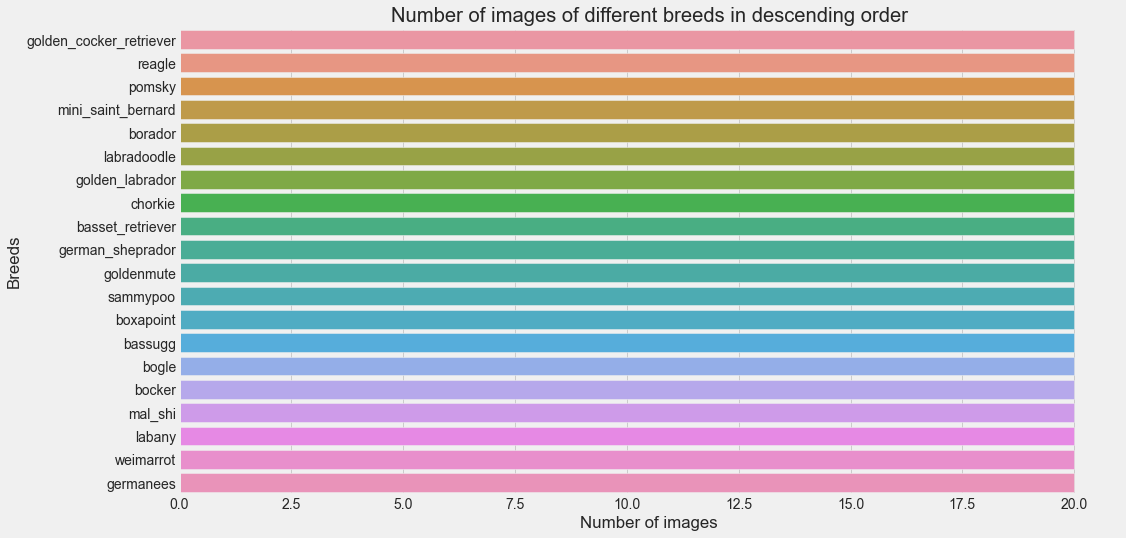

In [229]:
plt.figure(figsize=(15,8))
plt.title('Number of images of different breeds in descending order')
sns.barplot(x = 'Number of images', y = 'Breeds', data = df_test_breeds.sort_values('Number of images', ascending = False).head(30))
plt.show()

In [230]:
df_annot = pd.read_csv('mixed_breeds.csv')
df_annot.rename(columns={"breed": "Label"}, inplace=True)
df_annot.head()

,filename,images,Label,parent_1,parent_2
0,mixed_breeds/n01-basset_retriever/n01_0.jpeg,n01_0.jpeg,basset_retriever,basset,golden_retriever
1,mixed_breeds/n01-basset_retriever/n01_1.jpeg,n01_1.jpeg,basset_retriever,basset,golden_retriever
2,mixed_breeds/n01-basset_retriever/n01_2.jpeg,n01_2.jpeg,basset_retriever,basset,golden_retriever
3,mixed_breeds/n01-basset_retriever/n01_3.jpeg,n01_3.jpeg,basset_retriever,basset,golden_retriever
4,mixed_breeds/n01-basset_retriever/n01_4.jpeg,n01_4.jpeg,basset_retriever,basset,golden_retriever


In [231]:
valid = []

for element in os.listdir(image_path):
    for img_id in os.listdir(os.path.join(image_path, element)):
        path = os.path.join(element, img_id)
        label = element.split('-')[1]
        valid.append((path, label))          
        
df_test = pd.DataFrame(valid, columns = ['Path', 'Label'])
print('Shape of dataframe :', df_test.shape)

Shape of dataframe : (400, 2)


In [282]:
df_test = df_test.join(df_annot, lsuffix='1')
df_test = df_test[['Path', 'Label', 'parent_1', 'parent_2']]
df_test.head()

,Path,Label,parent_1,parent_2
0,n10-golden_cocker_retriever/n10_198.jpeg,basset_retriever,basset,golden_retriever
1,n10-golden_cocker_retriever/n10_194.jpeg,basset_retriever,basset,golden_retriever
2,n10-golden_cocker_retriever/n10_182.jpeg,basset_retriever,basset,golden_retriever
3,n10-golden_cocker_retriever/n10_183.jpeg,basset_retriever,basset,golden_retriever
4,n10-golden_cocker_retriever/n10_195.jpeg,basset_retriever,basset,golden_retriever


In [283]:
df_test = df_test.replace('shih-tzu', 'shih')
df_test = df_test.replace('german_short-haired_pointer', 'german_short')

### Get labels for each parent using same encoding as Stanford dataset

In [284]:
# use same labels as full standford dog dataset to allow matching parent breed during model testing
d1 = pd.DataFrame(0, index=np.arange(len(df_test)), columns=labels.columns)
d1.columns= d1.columns.str.lower()
d2 = pd.DataFrame(0, index=np.arange(len(df_test)), columns=labels.columns)
d2.columns= d2.columns.str.lower()

In [285]:
parent1_labels = pd.get_dummies(df_test['parent_1'])
parent2_labels = pd.get_dummies(df_test['parent_2'])

In [286]:
d1 = d1.add(parent1_labels).fillna(0)
d2 = d2.add(parent2_labels).fillna(0)
test_labels = d1.add(d2)

In [ ]:
idx2breed = dict(enumerate(test_labels.columns))

In [288]:
test_loader = loader(df_test, test_labels, batch_size = BATCH_SIZE, obj = 'test')

## Load trained model

In [5]:
# Load the saved model
PATH = 'inception_finetuning.pth'

In [7]:
inception = models.inception_v3(pretrained = True, aux_logits=False)

In [8]:
# Freeze model parameters
for param in inception.parameters():
    param.requires_grad = False

In [9]:
# Change the final layer of Inception Model for Transfer Learning
fc_inputs = inception.fc.in_features
inception.fc = nn.Sequential(
    nn.Linear(fc_inputs, 2048),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(2048, 120),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [ ]:
inception.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
inception.eval()

## Test model

In [60]:
test_data_size = len(df_test)

In [410]:
with torch.no_grad():
    both_parents_acc = 0.0
    at_least_1_parent_acc = 0.0
    for j, (inputs, labels) in enumerate(test_loader):
        parents_true = np.argpartition(labels, -2)[:,-2:].detach().numpy()
        outputs = inception(inputs)
        parents_pred = np.argpartition(outputs.detach().numpy(), -2)[:,-2:]
        
        for pred, true in zip(parents_pred, parents_true):
            both_parents_acc += len(np.intersect1d(pred, true))/2
        
        for pred, true in zip(parents_pred, parents_true):
            at_least_1_parent_acc += float(np.any(np.in1d(pred,true)))
        
both_parents_acc = both_parents_acc/float(test_data_size)
at_least_1_parent_acc = at_least_1_parent_acc/float(test_data_size)      

print('avg accuracy in detecting both parents: ', both_parents_acc, '\navg accuracy in detecting at least one parent:', at_least_1_parent_acc)

avg accuracy in detecting both parents:  0.0075 
avg accuracy in detecting at least one parent: 0.015
